In [18]:
import os
import math
from copy import deepcopy
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
print('PyTorch version:', th.__version__)
print('GPU:', th.version.cuda)

PyTorch version: 2.0.1+cu117
GPU: 11.7


In [ ]:
#!pip install dgl-cu117 -f https://data.dgl.ai/wheels/repo.html

In [20]:
def plot_losses(train_losses, val_losses, log=False):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(train_losses, label='Train')
    ax.plot(val_losses, label='Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Cross Entropy Loss')
    if log:
        ax.set_yscale('log')
    ax.legend()
    ax.grid(True)

In [78]:
def train_step(model, g, features, labels, train_mask, val_mask, optimizer, loss_fn):
    """Train one epoch"""
    model.train()

    optimizer.zero_grad()
    logits = model(g, features)
    loss = loss_fn(logits[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()
    
    with th.no_grad():
        val_loss = loss_fn(logits[val_mask], labels[val_mask])
    return loss.item(), val_loss.item()

@th.no_grad()
def test(model_cp, g, features, labels, split_idx, evaluator, best_path=None):
    model = deepcopy(model_cp)

    if best_path is not None:
        model.load_state_dict(th.load(best_path))

    model.eval()

    features = g.ndata['feat']
    logits = model(g, features)
    y_pred = logits.argmax(1, keepdim=True)
    
    train_acc = evaluator.eval({'y_true': labels[split_idx['train']].reshape(-1, 1), 
                                'y_pred': y_pred[split_idx['train']]})['acc']
    
    valid_acc = evaluator.eval({'y_true': labels[split_idx['valid']].reshape(-1, 1),
                                'y_pred': y_pred[split_idx['valid']]})['acc']
    
    test_acc = evaluator.eval({'y_true': labels[split_idx['test']].reshape(-1, 1),
                               'y_pred': y_pred[split_idx['test']]})['acc']
    
    
    return train_acc, valid_acc, test_acc

def train(g, labels, split_idx, model, epochs, evaluator, device, save_path, loss_fn=F.cross_entropy, lr=0.01, es_criteria=5, verbose=False):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_acc = 0
    best_test_acc = 0
    train_losses = []
    val_losses = []

    features = g.ndata['feat']

    train_mask = split_idx['train'].to(device)
    val_mask = split_idx['valid'].to(device)
    test_mask = split_idx['test'].to(device)
    es_iters = 0

    for e in range(1, epochs+1):
        train_loss, val_loss = train_step(model, g, features, labels, train_mask, val_mask, optimizer, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        #Compute accuracy on training validation and test data
        train_acc, val_acc, test_acc = test(model, g, features, labels, split_idx, evaluator)

        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
            th.save(model.state_dict(), save_path)
            es_iters = 0
        else:
            es_iters += 1

        if e % 50 == 0 and verbose:
            print(f'Epoch: {e:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_acc:.4f}, Best Train Acc: {best_val_acc:.4f}, Test Acc: {test_acc:.4f} Best Test Acc: {best_test_acc:.4f}')

        if es_iters >= es_criteria:
            print(f'Early stopping at epoch {e}')
            break
                    
    return np.array(train_losses), np.array(val_losses)

In [83]:
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl.nn.pytorch.conv import GraphConv
from ogb.nodeproppred import DglNodePropPredDataset, Evaluator

In [84]:
device = 'cuda' if th.cuda.is_available() else 'cpu'
device = th.device(device)
print('Device:', device)

Device: cuda


In [27]:
dataset = DglNodePropPredDataset(name='ogbn-arxiv', root='dataset/')

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:29<00:00,  2.75it/s]


Extracting dataset/arxiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]


Converting graphs into DGL objects...


100%|██████████| 1/1 [00:00<00:00, 254.40it/s]

Saving...


In [85]:
val_acc_lb, val_acc_lb_var, test_acc_lb, test_acc_lb_var = 0.7300, 0.0017, 0.7174, 0.0029
evaluator = Evaluator(name='ogbn-arxiv')

In [86]:
split_idx = dataset.get_idx_split()
g = dataset.graph[0].to(device)
labels = dataset.labels.flatten().to(device)

In [87]:
g.num_edges()

1166243

In [88]:
g = g.add_self_loop()
g = dgl.add_reverse_edges(g)

In [89]:
g.num_edges()

2501829

In [90]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes, num_layers, add_bn=True, dropout=0):
        """
        add_bn: Whether to add batch normalization layer after each graph convolution layer
        """
        super(GCN, self).__init__()
        
        self.add_bn = add_bn
        self.dropout = dropout
        
        #Input layer
        self.convs = nn.ModuleList()
        self.convs.append(GraphConv(in_feats, h_feats)) # in_feats -> h_feats
        if self.add_bn:
            self.bns = nn.ModuleList()
            self.bns.append(nn.BatchNorm1d(h_feats))

        #Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GraphConv(h_feats, h_feats)) # h_feats -> h_feats   
            if self.add_bn:
                self.bns.append(nn.BatchNorm1d(h_feats))
        
        #Output layer
        self.convs.append(GraphConv(h_feats, num_classes)) # h_feats -> num_classes
        
    def forward(self, g, in_feat):
        h = in_feat
        for i, conv in enumerate(self.convs[:-1]):
            h = conv(g, h)
            if self.add_bn:
                h = self.bns[i](h)
            h = F.relu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.convs[-1](g, h)
        return h

In [91]:
model_kwargs = dict(
    in_feats=g.ndata['feat'].shape[1],
    h_feats=256,
    num_classes=dataset.num_classes,
    num_layers=3,
    dropout=0.5,
    add_bn=True
)
model = GCN(**model_kwargs).to(device)

In [92]:
model

GCN(
  (convs): ModuleList(
    (0): GraphConv(in=128, out=256, normalization=both, activation=None)
    (1): GraphConv(in=256, out=256, normalization=both, activation=None)
    (2): GraphConv(in=256, out=40, normalization=both, activation=None)
  )
  (bns): ModuleList(
    (0-1): 2 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [93]:
model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_params

110120

In [94]:
model_path = 'models/'
Path(model_path).mkdir(parents=True, exist_ok=True)
gcn_path = os.path.join(model_path, 'gcn_base.model')

In [95]:
train_args = dict(
    g=g,
    labels=labels,
    split_idx=split_idx,
    epochs=500,
    evaluator=evaluator,    
    device=device,
    save_path=gcn_path,
    lr=5e-3,
    es_criteria=50)

In [96]:
train_losses, val_losses = train(model=model, verbose=True, **train_args)

Epoch: 050, Train Loss: 1.0393, Val Loss: 0.6943, Best Train Acc: 0.6955, Test Acc: 0.6851 Best Test Acc: 0.6868
Epoch: 100, Train Loss: 0.9384, Val Loss: 0.7139, Best Train Acc: 0.7186, Test Acc: 0.7010 Best Test Acc: 0.7115
Epoch: 150, Train Loss: 0.8807, Val Loss: 0.7189, Best Train Acc: 0.7229, Test Acc: 0.7095 Best Test Acc: 0.7137
Epoch: 200, Train Loss: 0.8421, Val Loss: 0.7204, Best Train Acc: 0.7252, Test Acc: 0.7056 Best Test Acc: 0.7165
Epoch: 250, Train Loss: 0.8122, Val Loss: 0.7268, Best Train Acc: 0.7289, Test Acc: 0.7169 Best Test Acc: 0.7189
Epoch: 300, Train Loss: 0.7834, Val Loss: 0.7238, Best Train Acc: 0.7294, Test Acc: 0.7109 Best Test Acc: 0.7177
Epoch: 350, Train Loss: 0.7648, Val Loss: 0.7292, Best Train Acc: 0.7309, Test Acc: 0.7144 Best Test Acc: 0.7194
Epoch: 400, Train Loss: 0.7452, Val Loss: 0.7209, Best Train Acc: 0.7324, Test Acc: 0.7139 Best Test Acc: 0.7171
Early stopping at epoch 407


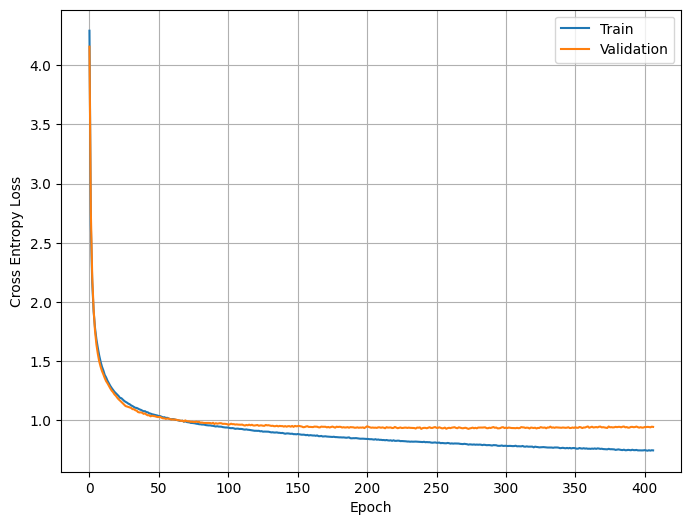

In [97]:
plot_losses(train_losses, val_losses)

In [116]:
def loge(x, labels):
    epsilon = 1 - math.log(2)
    z = F.cross_entropy(x, labels, reduction='none')
    y = th.log(epsilon + z) - math.log(epsilon)
    return y.mean()

In [117]:
model_loge_kwargs = dict(
    in_feats=g.ndata['feat'].shape[1],
    h_feats=256,
    num_classes=dataset.num_classes,
    num_layers=3,
    dropout=0.5,
    add_bn=True
)
model_loge = GCN(**model_loge_kwargs).to(device)

In [118]:
gcn_loge_path = os.path.join(model_path, 'gcn_loge.model')

In [119]:
train_loge_args = dict(
    g=g,
    labels=labels,
    split_idx=split_idx,
    epochs=500,
    evaluator=evaluator,
    device=device,
    save_path=gcn_loge_path,
    lr=5e-3,
    es_criteria=50,
    loss_fn=loge)

In [120]:
train_losses, val_losses = train(model=model_loge, verbose=True, **train_loge_args)

Epoch: 050, Train Loss: 0.9007, Val Loss: 0.7018, Best Train Acc: 0.7018, Test Acc: 0.6952 Best Test Acc: 0.6952
Epoch: 100, Train Loss: 0.8103, Val Loss: 0.7218, Best Train Acc: 0.7220, Test Acc: 0.7129 Best Test Acc: 0.7139
Epoch: 150, Train Loss: 0.7661, Val Loss: 0.7185, Best Train Acc: 0.7305, Test Acc: 0.6999 Best Test Acc: 0.7159
Epoch: 200, Train Loss: 0.7370, Val Loss: 0.7201, Best Train Acc: 0.7306, Test Acc: 0.7009 Best Test Acc: 0.7227
Epoch: 250, Train Loss: 0.7165, Val Loss: 0.7283, Best Train Acc: 0.7319, Test Acc: 0.7239 Best Test Acc: 0.7227
Early stopping at epoch 264


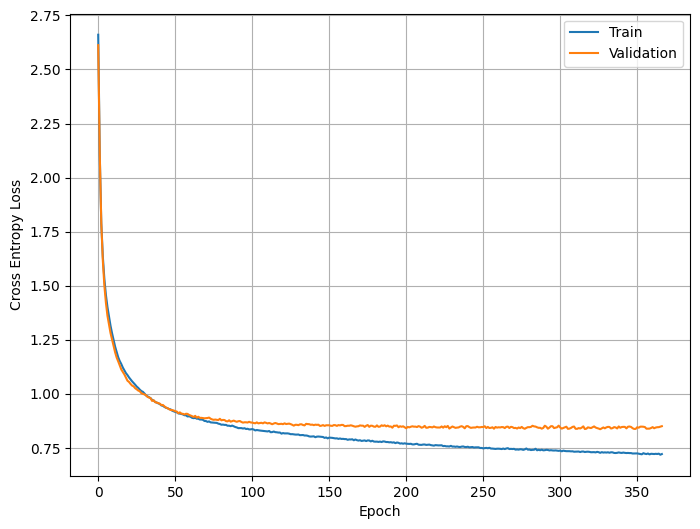

In [104]:
plot_losses(train_losses, val_losses)

In [106]:
class GCNwLinear(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes, num_layers, dropout):
        super(GCNwLinear, self).__init__()
        
        self.dropout = dropout
        self.num_layers = num_layers

        # Layer containers
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.linear = nn.ModuleList()
        
        # Input layer
        self.input_drop = nn.Dropout(min(0.1, dropout))
        self.convs.append(GraphConv(in_feats, h_feats, bias=False))
        self.bns.append(nn.BatchNorm1d(h_feats))
        self.linear.append(nn.Linear(in_feats, h_feats, bias=False))

        # Hidden layers 
        for _ in range(num_layers - 2):
            self.convs.append(GraphConv(h_feats, h_feats, bias=False))
            self.bns.append(nn.BatchNorm1d(h_feats))
            self.linear.append(nn.Linear(h_feats, h_feats, bias=False))
        
        # Output layer
        self.convs.append(GraphConv(h_feats, num_classes, bias=False))
        self.linear.append(nn.Linear(h_feats, num_classes, bias=False))

    def forward(self, g, in_feat):
        h = in_feat
        h = self.input_drop(h)

        for i in range(self.num_layers):
            c = self.convs[i](g, h)
            linear = self.linear[i](h)

            h = c + linear

            if i < self.num_layers - 1:
                h = self.bns[i](h)
                h = F.relu(h)
                h = F.dropout(h, p=self.dropout, training=self.training)
        
        return h        

In [123]:
model_linear_kwargs = dict(
    in_feats=g.ndata['feat'].shape[1],
    h_feats=256,
    num_classes=dataset.num_classes,
    num_layers=6,
    dropout=0.5)
model_linear = GCNwLinear(**model_linear_kwargs).to(device)

In [124]:
gcn_linear_path = os.path.join(model_path, 'gcn_linear.model')
# https://arxiv.org/pdf/2103.13355.pdf
# https://arxiv.org/pdf/2108.10521.pdf
# https://cs.stanford.edu/people/jure/pubs/gcnlpa-tois21.pdf

In [125]:
train_linear_args = dict(
    g=g,
    labels=labels,
    split_idx=split_idx,
    epochs=500,
    evaluator=evaluator,
    device=device,
    save_path=gcn_linear_path,
    lr=5e-3,
    es_criteria=50,
    loss_fn=loge) 


In [126]:
train_losses, val_losses = train(model=model_linear, verbose=True, **train_linear_args)

Epoch: 050, Train Loss: 0.9441, Val Loss: 0.6946, Best Train Acc: 0.6947, Test Acc: 0.6918 Best Test Acc: 0.6883
Epoch: 100, Train Loss: 0.8385, Val Loss: 0.7261, Best Train Acc: 0.7261, Test Acc: 0.7065 Best Test Acc: 0.7065
Epoch: 150, Train Loss: 0.7938, Val Loss: 0.7202, Best Train Acc: 0.7329, Test Acc: 0.6955 Best Test Acc: 0.7170
Early stopping at epoch 167


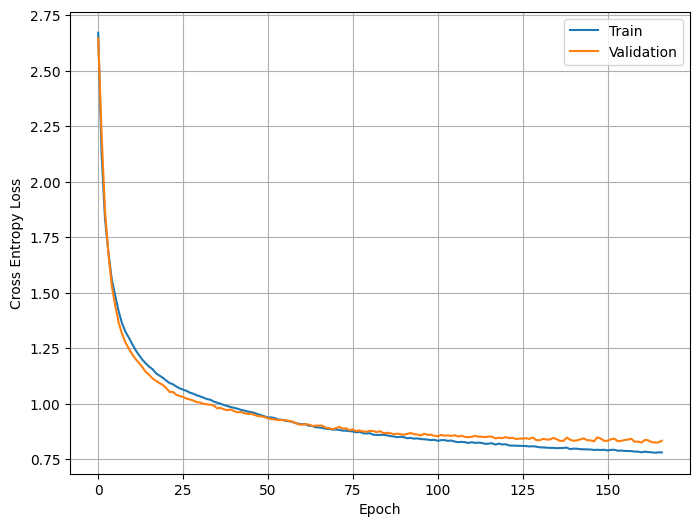

In [127]:
plot_losses(train_losses, val_losses)